In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
filtered_df = pd.read_parquet("../.data/processed/filtered_user_features.parquet")

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Liste des variables retenues
features = [
    "count_view", "count_cart", "count_purchase",
    "unique_sessions", "active_days", "recency_days",
    "total_spent", "avg_purchase_price"
]

# Filtrage des utilisateurs actifs déjà effectué dans filtered_df
X = filtered_df[features].copy()

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7841232 entries, 0 to 7841231
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   count_view          int64  
 1   count_cart          int64  
 2   count_purchase      int64  
 3   unique_sessions     int64  
 4   active_days         int64  
 5   recency_days        int64  
 6   total_spent         float64
 7   avg_purchase_price  float64
dtypes: float64(2), int64(6)
memory usage: 478.6 MB


In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Copie de X pour transformation
X_transformed = X.copy()

# Variables à transformer avec log(1 + x)
log_features = ["count_view", "count_cart",
                "count_purchase", "total_spent", "avg_purchase_price"]
X_transformed[log_features] = X_transformed[log_features].apply(
    lambda x: np.log1p(x))

# Standardisation finale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)

In [7]:
import numpy as np

sample_size = 100_000
np.random.seed(42)

# Créer un échantillon de lignes aléatoires à partir de X_scaled
indices = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sampled = X_scaled[indices]

INFO:DBSCAN_Clustering:Début du test DBSCAN avec différentes valeurs de eps
INFO:DBSCAN_Clustering:Test DBSCAN avec eps = 0.3
INFO:DBSCAN_Clustering:Nombre de clusters détectés (hors bruit): 232
INFO:DBSCAN_Clustering:Score silhouette: -0.1366
INFO:DBSCAN_Clustering:Test DBSCAN avec eps = 0.5
INFO:DBSCAN_Clustering:Nombre de clusters détectés (hors bruit): 49
INFO:DBSCAN_Clustering:Score silhouette: 0.0531
INFO:DBSCAN_Clustering:Test DBSCAN avec eps = 0.7
INFO:DBSCAN_Clustering:Nombre de clusters détectés (hors bruit): 11
INFO:DBSCAN_Clustering:Score silhouette: 0.1291
INFO:DBSCAN_Clustering:Test DBSCAN avec eps = 1.0
INFO:DBSCAN_Clustering:Nombre de clusters détectés (hors bruit): 5
INFO:DBSCAN_Clustering:Score silhouette: 0.5163
INFO:DBSCAN_Clustering:Test DBSCAN avec eps = 1.2
INFO:DBSCAN_Clustering:Nombre de clusters détectés (hors bruit): 5
INFO:DBSCAN_Clustering:Score silhouette: 0.5229


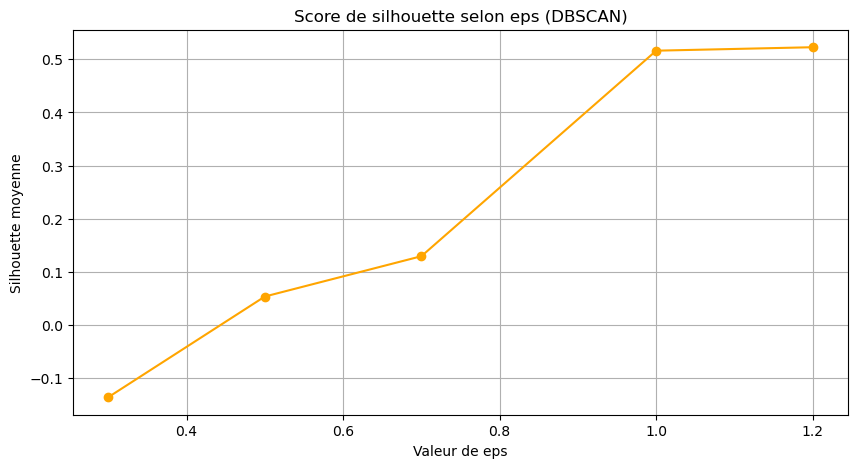

In [9]:
import logging
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Configurer le logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("DBSCAN_Clustering")

logger.info("Début du test DBSCAN avec différentes valeurs de eps")
eps_values = [0.3, 0.5, 0.7, 1.0, 1.2]
min_samples = 5
silhouette_scores_dbscan = []

for eps in eps_values:
    logger.info(f"Test DBSCAN avec eps = {eps}")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_sampled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    logger.info(f"Nombre de clusters détectés (hors bruit): {n_clusters}")

    if n_clusters > 1:
        score = silhouette_score(X_sampled, labels)
        logger.info(f"Score silhouette: {score:.4f}")
        silhouette_scores_dbscan.append(score)
    else:
        logger.warning(
            "Pas assez de clusters pour calculer un score de silhouette")
        silhouette_scores_dbscan.append(float("nan"))

# Affichage
plt.figure(figsize=(10, 5))
plt.plot(eps_values, silhouette_scores_dbscan, marker='o', color='orange')
plt.title("Score de silhouette selon eps (DBSCAN)")
plt.xlabel("Valeur de eps")
plt.ylabel("Silhouette moyenne")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sample_size = 1_000_000
np.random.seed(42)

# Créer un échantillon de lignes aléatoires à partir de X_scaled
indices = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sampled = X_scaled[indices]
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    logger.info(f"Training KMeans with k={k} on {sample_size} samples...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_sampled)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_sampled, kmeans.labels_)

    logger.info(f"k={k}: Inertia={inertia:.2f}, Silhouette={silhouette:.4f}")

    inertias.append(inertia)
    silhouette_scores.append(silhouette)

# Courbe du coude
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode du coude – Inertie en fonction du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.grid(True)
plt.show()

# Score silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='s', color='green')
plt.title("Score de silhouette moyen selon k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette moyenne")
plt.grid(True)
plt.show()

INFO:__main__:Training KMeans with k=2 on 1000000 samples...
